In [8]:
import pandas as pd
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

WORK_DIR = '../'
results_dir = os.path.join(WORK_DIR, 'results', 'estimates')

In [16]:
df_stats = []

for experiment in os.listdir(results_dir):
    if experiment.startswith('.'):
        continue

    print(f"Processing {experiment}")

    # emb_stats = pd.read_csv(os.path.join(results_dir, 'embeddings_stats.csv'))
    # emb_stats.rename(columns={'time':'chunk emb time (seconds)','size (bytes)': 'chunk size (bytes)', 'n_samples': 'samples per chunk'}, inplace=True)

    downstream_stats = pd.read_csv(os.path.join(results_dir, experiment, 'downstream_stats.csv'))
    downstream_stats.rename(columns={'time':'chunk training time (seconds)'}, inplace=True)
    downstream_stats['samples per chunk'] = 50000
    downstream_stats['samples per chunk'] = np.where(downstream_stats['task'] == 'enhancer annotation', 28, downstream_stats['samples per chunk'])
    downstream_stats['samples per chunk'] = np.where(downstream_stats['task'] == 'gene finding', 4768, downstream_stats['samples per chunk'])

    # df_merged = pd.merge(
    #     emb_stats,
    #     downstream_stats,
    #     on=['model', 'task'],
    #     how='outer',
    #     suffixes=('_emb', '_downstream'),
    # )
    # df_merged = df_merged.sort_values(by=['task', 'model'])
    downstream_stats['Experiment'] = experiment
    df_stats.append(downstream_stats)

df_stats = pd.concat(df_stats, ignore_index=True)
df_stats = df_stats[df_stats['model'] == 'hyenadna-tiny-1k']

Processing default
Processing batch


In [17]:
task_len = {}
for task in df_stats['task'].unique():
    df_task = pd.read_csv(os.path.join(WORK_DIR, 'data',task, f'{task}.bed'), sep='\t', low_memory=False)
    task_len[task] = len(df_task)

df_stats['total samples'] = df_stats['task'].map(task_len)
df_stats['n chunks'] = df_stats['total samples'] / df_stats['samples per chunk']

# df_stats['chunk size (GB)'] = df_stats['chunk size (bytes)'] / (1024 ** 3)

# df_stats['total emb time (hours)'] = (df_stats['chunk emb time (seconds)'] * df_stats['n chunks']) / 3600
# df_stats['total emb time (days)'] = df_stats['total emb time (hours)'] / 24
# df_stats['total emb size (GB)'] = df_stats['chunk size (bytes)'] * df_stats['n chunks'] / (1024 ** 3)

df_stats['epoch training time (hours)'] = df_stats['chunk training time (seconds)'] * df_stats['n chunks'] / 3600
total_epochs = 100
df_stats['total training time (hours)'] = df_stats['epoch training time (hours)'] * total_epochs
df_stats['total training time (days)'] = df_stats['total training time (hours)'] / 24

df_stats

,task,model,epoch,chunk training time (seconds),samples per chunk,Experiment,total samples,n chunks,epoch training time (hours),total training time (hours),total training time (days)
0,gene_finding,hyenadna-tiny-1k,1,162.424445,50000,default,5977,0.11954,0.005393,0.539339,0.022472
1,enhancer_annotation,hyenadna-tiny-1k,1,14.042472,50000,default,285,0.00570,0.000022,0.002223,0.000093
2,histone_modification,hyenadna-tiny-1k,1,120.563790,50000,default,625229,12.50458,0.418778,41.877765,1.744907
3,chromatin_accessibility,hyenadna-tiny-1k,1,121.548147,50000,default,2062129,41.24258,1.392489,139.248866,5.802036
4,cpg_methylation,hyenadna-tiny-1k,1,122.220143,50000,default,959039,19.18078,0.651188,65.118824,2.713284
40,histone_modification,hyenadna-tiny-1k,1,70.368401,50000,batch,625229,12.50458,0.244424,24.442425,1.018434
41,gene_finding,hyenadna-tiny-1k,1,135.231373,50000,batch,5977,0.11954,0.004490,0.449043,0.018710


In [18]:
# df_stats.groupby(['model']).sum(numeric_only=True).sort_values(by='total emb size (GB)', ascending=False)['total emb size (GB)']

In [19]:
# df_stats = df_stats[df_stats['model'] != 'awdlstm'] # Exclude awdlstm as it is an outlier in terms of size and time

In [20]:
# sns.barplot(data=df_stats.sort_values(by='total emb size (GB)', ascending=False), x='task', y='total emb size (GB)', hue='model')
# plt.xticks(rotation=45)

In [21]:
# sns.barplot(data=df_stats.sort_values(by='total emb time (days)', ascending=False), x='task', y='total emb time (days)', hue='model')
# plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'chromatin_accessibility'),
  Text(1, 0, 'cpg_methylation'),
  Text(2, 0, 'histone_modification'),
  Text(3, 0, 'gene_finding'),
  Text(4, 0, 'enhancer_annotation')])

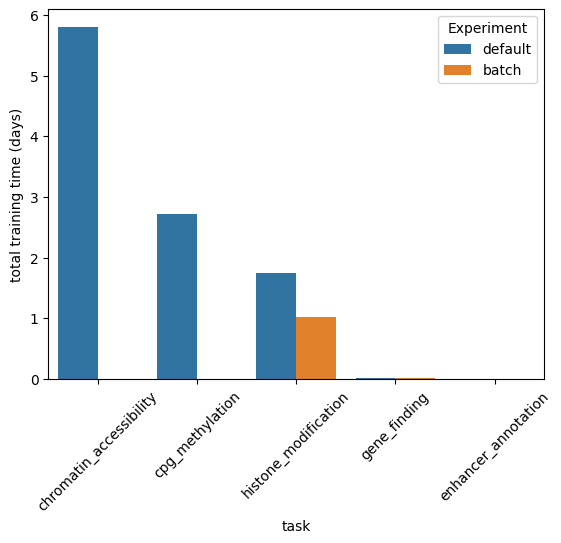

In [22]:
sns.barplot(data=df_stats.sort_values(by='total training time (days)', ascending=False), x='task', y='total training time (days)', hue='Experiment')
plt.xticks(rotation=45)